In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from DataLoader import DataLoader
import datetime
import random
import warnings
from BehaviourFeatureExtractor import BehaviourFeatureExtractor, convert_seconds_to_frame
from VocalFeatureExtractor import VocalFeatureExtractor
from colour import Color
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
import sys
import cv2

## Data loading ##

In [6]:
data_dir = "data"
DL = DataLoader(data_dir, path_to_config_file="config.json")
BF = BehaviourFeatureExtractor("config.json")
VF = VocalFeatureExtractor("config.json")

In [7]:
mouse_ids = ["MBI5335RR", "VBQ0261L"]
days = [f"d{i}" for i in range(1, 7)]

experiment_data = {}

for ms_id in mouse_ids:
    experiment_data[ms_id] = {}
    for d in days:
        # Load data
        data = DL.get_data_for_experiment(mouse_id = ms_id,
                                          day = d)
        if data is None:
            print("Data not found for mouse", ms_id, "on day", d)
            continue

        experiment_data[ms_id][d] = data

        df_DLC = experiment_data[ms_id][d]["Behavior"]["df_dlc"].copy()
        df_Avi = experiment_data[ms_id][d]["Avisoft"]["df"].copy()
        df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()

        # align USV data to DLC data
        df_DLC_processed, _ = BF.process_DLC(df_DLC.copy(), df_summary)
        trials, df_DLC, df_USV = VF.process_USV(df_Avi, df_summary, df_DLC_processed)
        experiment_data[ms_id][d]["trials"] =  trials

----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance t

## Video functions ##

In [8]:
def load_video_segment(video_path, start_time=None, end_time=None):
    """
    Load a segment of a video file between start_time and end_time.
    
    Parameters:
        video_path (str): Path to the video file
        start_time (float): Start time in seconds
        end_time (float): End time in seconds
        
    Returns:
        tuple: (video_array, fps)
    """
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # If times are not specified, use None values
    if start_time is not None:
        start_frame = int(start_time * fps)
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    else:
        start_frame = 0
        
    if end_time is not None:
        end_frame = int(end_time * fps)
    else:
        end_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate number of frames to read
    n_frames = end_frame - start_frame
    
    # Read first frame to get dimensions
    ret, frame = cap.read()
    if not ret:
        raise ValueError("Could not read video file")
    
    height, width, channels = frame.shape
    
    # Initialize array only for the segment we want
    video_array = np.empty((n_frames, height, width, channels), dtype=np.uint8)
    video_array[0] = frame
    
    # Read only the frames we need
    frame_idx = 1
    while frame_idx < n_frames:
        ret, frame = cap.read()
        if not ret:
            break
        video_array[frame_idx] = frame
        frame_idx += 1
    
    cap.release()
    
    return video_array

def extract_trial_video_efficient(video_path, experiment_data, mouse_id, day,
                                trial_num=None, start_time=None, end_time=None):
                                  
    # If start and end times not specified, get them from experiment_data
    if start_time is None or end_time is None:
        if trial_num is None:
            raise ValueError("Must provide either start_time/end_time or trial_num")
        df_summary = experiment_data[mouse_id][day]["Behavior"]["df_summary"]
        start_time = df_summary.loc[df_summary[BF.DLC_summary_cols['trial_num']] == trial_num, BF.DLC_summary_cols['pup_displacement']].values[0]
        end_time = df_summary.loc[df_summary[BF.DLC_summary_cols['trial_num']] == trial_num, BF.DLC_summary_cols['trial_end']].values[0]

    # Load only the video segment we need
    video_array = load_video_segment(video_path, 
                                        start_time=start_time,
                                        end_time=end_time)
    
    return video_array

def save_trial_video(trial_video, output_path, fps = 30):
    height, width = trial_video.shape[1:3]
    
    # Use H.264 codec
    fourcc = cv2.VideoWriter_fourcc(*'avc1')  # Changed from 'mp4v' to 'avc1'
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Write frames
    for frame in trial_video:
        out.write(frame.astype(np.uint8))
    
    # Release the video writer
    out.release()


### Example usage ###

In [9]:
interesting_trial_ids = [("VBQ0261L", "d4", 6),
                        ("MBI5335RR", "d1", 1),
                        ("VBQ0261L", "d2", 4),
                        ("MBI5335RR", "d3", 4)]

In [10]:
mouse_id, day, trial_num = interesting_trial_ids[0]

df_summary = experiment_data[mouse_id][day]["Behavior"]["df_summary"]
fps = BF.frame_rate

# Load the video
video_path = DL.video_dict[mouse_id][day]
# Extract a specific trial
trial_video = extract_trial_video_efficient(video_path, experiment_data, mouse_id, day,
                                trial_num)
# Save the trial video
print(trial_video.shape)


(158, 480, 640, 3)


The trial_video array is a 4-dimensional NumPy array where each dimension represents:
1. First dimension: Number of frames in the video segment
2. Second dimension: Height of each frame in pixels
3. Third dimension: Width of each frame in pixels
4. Fourth dimension: Color channels (typically 3 for RGB format)

### Loading the pick up sequence from the video ###

In [91]:
def find_pickup_point_in_video(experiment_data, mouse_id, day, trial_num):

    df_summary = experiment_data[mouse_id][day]["Behavior"]["df_summary"].copy()
    trial_pickup_time = df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num,
                                                 BF.DLC_summary_cols["mouse_first_pick_up"]].values[0]
    trial_start_time = df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num,
                                                 BF.DLC_summary_cols["pup_displacement"]].values[0]
    trial_end_time = df_summary.loc[df_summary[BF.DLC_summary_cols["trial_num"]] == trial_num,
                                                 BF.DLC_summary_cols["trial_end"]].values[0]

    return trial_pickup_time, trial_start_time, trial_end_time

def label_pup_interaction_behaviors(experiment_data, mouse_id, day, trial_num,
                                  event_time_point, kernel_size=20,
                                  pre_event_window_size_time=10, frame_rate=30):
    """Labels mouse behaviors (approach, crouching, active interaction) in the time window before pup pickup"""
    
    # Get required data from experiment_data
    df_summary = experiment_data[mouse_id][day]["Behavior"]["df_summary"].copy()
    trial_DLC = experiment_data[mouse_id][day]["trials"][trial_num]["dlc_data"].copy()
    
    # conversion to frames
    event_time_point_frame = convert_seconds_to_frame(event_time_point, frame_rate)
    pre_event_window_size_frames = convert_seconds_to_frame(pre_event_window_size_time, frame_rate)

    trial_start_frame_index = trial_DLC["frame_index"].iloc[0]
    start_frame_index = event_time_point_frame - pre_event_window_size_frames

    if start_frame_index < trial_start_frame_index:
        warnings.warn(f"Window is too big, spills over trial start, resetting window size to {trial_start_frame_index - start_frame_index}")
        pre_event_window_size_frames = trial_start_frame_index - start_frame_index

    # Get window of interest
    window = trial_DLC.loc[start_frame_index:event_time_point_frame].copy()

    # Calculate distance to pup center
    pup_corner_bounds = BF.extract_pup_starting_position_bounds(df_summary, trial_num)
    pup_center_x = pup_corner_bounds["xmin"] + (pup_corner_bounds["xmax"] - pup_corner_bounds["xmin"]) / 2
    pup_center_y = pup_corner_bounds["ymin"] + (pup_corner_bounds["ymax"] - pup_corner_bounds["ymin"]) / 2
    window["distance_mouse_pup_center"] = np.sqrt((window["mouse_x"] - pup_center_x)**2 + (window["mouse_y"] - pup_center_y)**2)
    window["distance_head_pup_center"] = np.sqrt((window["head_x"] - pup_center_x)**2 + (window["head_y"] - pup_center_y)**2)

    # Convert distances to cm and calculate derivatives
    columns = [BF.DLC_behaviour_cols["mouse_speed"], "distance_mouse_pup_center", "distance_head_pup_center"]
    px_cm_ratio = BF.config["pixels_to_cm_ratio"]
    for col in columns:
        window[col+"_cm"] = window[col] / px_cm_ratio
        window[col+"_cm_deriv"] = np.gradient(window[col+"_cm"])

    # Smooth derivatives
    kernel = np.ones(kernel_size) / kernel_size
    window["mouse_speed_px/s_cm_convolved"] = np.convolve(window["mouse_speed_px/s_cm"], kernel, mode='same')
    window["mouse_speed_px/s_cm_deriv_convolved"] = np.gradient(window["mouse_speed_px/s_cm_convolved"])
    window["distance_mouse_pup_center_cm_deriv_convolved"] = np.convolve(window["distance_mouse_pup_center_cm_deriv"], kernel, mode='same')

    # Label behaviors
    mask_approach = (window["distance_mouse_pup_center_cm_deriv_convolved"] < -0.1)
    mask_crouching = (window["distance_mouse_pup_center_cm"] < 2) & (window["mouse_speed_px/s_cm_convolved"] < 5)
    mask_active_interaction = (window["distance_head_pup_center_cm"] < 2) & (window["mouse_speed_px/s_cm_convolved"] < 5)
        
    # mask approach, crouching and active interaction
    mask_crouching[mask_active_interaction] = False
    mask_approach[mask_crouching | mask_active_interaction] = False
    window["in_nest"][mask_approach | mask_crouching | mask_active_interaction] = False
    
    window["approach"] = mask_approach
    window["crouching"] = mask_crouching
    window["active_interaction"] = mask_active_interaction


    return window

def plot_pup_usv_to_pickup_point(experiment_data, ms_id, d, trial_num, window = None):
    """Plots the labeled behaviors and USV data leading up to pup pickup"""
    
    #df_summary = experiment_data[ms_id][d]["Behavior"]["df_summary"].copy()
    #trials = experiment_data[ms_id][d]["trials"].copy()
    #trial_DLC = trials[trial_num]["dlc_data"].copy()
    
    # clearing the plot
    plt.close('all')

    trial_pickup_time, trial_start_time, trial_end_time = find_pickup_point_in_video(experiment_data, mouse_id, day, trial_num)
    trial_pickup_time_minutes = f"{str(int(trial_pickup_time//60))}:{int(trial_pickup_time%60)}"
    trial_start_time_minutes = f"{str(int(trial_start_time//60))}:{int(trial_start_time%60)}"

    if window is None:
        window = label_pup_interaction_behaviors(experiment_data, ms_id, d, trial_num,
                                                trial_pickup_time)  
    else:
        window = window.copy()                                         
    
    # Create plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    window.plot(x="time_seconds", y=["distance_mouse_pup_center_cm"], color="blue", ax=ax)

    # Add behavior shading
    for behavior, color in [("crouching", "red"), ("approach", "green"), 
                          ("in_nest", "cyan"), ("active_interaction", "blue")]:
        for i in range(len(window[behavior])):
            if window[behavior].iloc[i]:
                ax.axvspan(window["time_seconds"].iloc[i],
                          window["time_seconds"].iloc[i]+1/30,
                          facecolor=color, alpha=0.5)

    # Add pickup point indicator
    # trial_pickup_time = window["time_seconds"].iloc[-1]
    ax.axvspan(trial_pickup_time, trial_pickup_time + 1/30,
               facecolor='magenta', alpha=0.5)

    # Add USV plot
    ax2 = ax.twinx()
    window.plot(x="time_seconds", y=["average_frequency"],
                ax=ax2, kind="scatter", color="purple")
    ax2.set_ylabel("Average frequency of USVs (kHz)", color="purple")

    # Add legend
    legend_elements = [
        mpatches.Patch(color='green', label='approach', alpha=0.5),
        mpatches.Patch(color='red', label='crouch', alpha=0.5),
        mpatches.Patch(color='cyan', label='In nest', alpha=0.5),
        mpatches.Patch(color='blue', label='Active interaction', alpha=0.5),
        mpatches.Patch(color='magenta', label='Pick up point', alpha=0.5),
        mlines.Line2D([], [], color='blue', label='Distance to pup')
    ]
    ax.legend(handles=legend_elements, loc="best")

    ax.set_title(f"{ms_id} - {d} - Trial {trial_num}: Distance to pup and USV to pick up point at {trial_pickup_time_minutes}, trial start was at {trial_start_time_minutes}")
    #plt.show()
    

(97, 480, 640, 3)


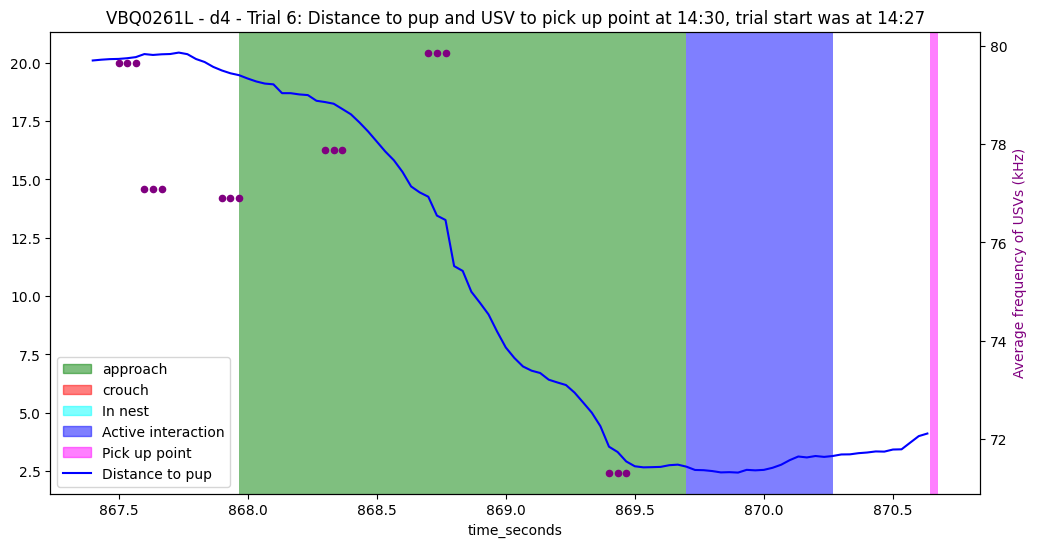

In [79]:
mouse_id, day, trial_num = interesting_trial_ids[0]

df_summary = experiment_data[mouse_id][day]["Behavior"]["df_summary"]
fps = BF.frame_rate

# Load the video
video_path = DL.video_dict[mouse_id][day]

pickup_time, start_trial, end_trial = find_pickup_point_in_video(experiment_data, mouse_id, day, trial_num)

window = label_pup_interaction_behaviors(experiment_data, mouse_id, day, trial_num,
                                  event_time_point = pickup_time, kernel_size=20,
                                  pre_event_window_size_time=10, frame_rate=30)

start_time, end_time = window["time_seconds"].iloc[0], window["time_seconds"].iloc[-1]    

# Extract a specific trial
trial_video = extract_trial_video_efficient(video_path, experiment_data,
                                            mouse_id, day, trial_num, start_time, end_time)

print(trial_video.shape)

plot_pup_usv_to_pickup_point(experiment_data, mouse_id, day, trial_num, window)


### Editing the video to reflect behavioral annotations ###

In [44]:
def apply_behavior_shading(video_array,
                           behavior_window,
                           pickup_frame_index, 
                           alpha=0.3, 
                           pickup_window_size=5):
    """
    Applies colored shading to video frames based on detected behaviors
    
    Args:
        video_array: numpy array of shape (frames, height, width, channels)
        behavior_window: pandas DataFrame containing behavior labels for each frame
        pickup_frame_index: frame index where pickup occurs
        alpha: transparency of the shading (0-1)
        pickup_window_size: number of frames before/after pickup to highlight
        
    Returns:
        numpy array with same shape as video_array but with behavior shading applied
    """
    # Create a copy to avoid modifying original
    shaded_video = video_array.copy()

    total_seconds = {behavior: 0 for behavior in ["in_nest", "active_interaction",
                                                    "approach", "crouching"]}
    
    # Color mapping for behaviors (BGR format for OpenCV)
    color_map = {
        'in_nest': (255, 255, 0),           # cyan in BGR
        'active_interaction': (255, 0, 0),  # blue in BGR  
        'approach': (0, 255, 0),            # green in BGR
        'crouching': (0, 0, 255),           # red in BGR
        'pickup_point': (255, 0, 255)       # magenta in BGR
    }
    
    # Calculate pickup window bounds
    pickup_start = max(0, pickup_frame_index - pickup_window_size)
    pickup_end = min(len(video_array), pickup_frame_index + pickup_window_size)
    
    # For each frame
    for frame_idx in range(len(behavior_window)):
        # Get current frame
        frame = shaded_video[frame_idx]
        overlay = frame.copy()
        
        # Apply behavior shading
        for behavior, color in color_map.items():
            if behavior == 'pickup_point':
                continue
                
            if behavior_window[behavior].iloc[frame_idx]:
                overlay = cv2.addWeighted(
                    overlay, 
                    1-alpha,
                    np.full_like(frame, color), 
                    alpha, 
                    0
                )

                total_seconds[behavior] += 1/30
                
        
        # Special handling for pickup point - make it more prominent
        # if pickup_start <= frame_idx <= pickup_end:
        #     # Calculate intensity based on distance from pickup point
        #     distance_from_pickup = abs(frame_idx - pickup_frame_index)
        #     pickup_alpha = alpha * (1 - distance_from_pickup/pickup_window_size)
            
        #     overlay = cv2.addWeighted(
        #         overlay,
        #         1-pickup_alpha,
        #         np.full_like(frame, color_map['pickup_point']),
        #         pickup_alpha,
        #         0
        #     )
            
        shaded_video[frame_idx] = overlay
    
    print(total_seconds)
    return shaded_video

0. Video loaded from: data/MBI5335RR/MBI5335RR_240304_d1/MBI5335RR_d1DLC_resnet50_behav_trajectories_Oct2024Oct24shuffle1_100000_filtered_labeled.mp4
1. Behaviors labeled
Start time: 377.76666666666665 End time: 387.76666666666665
Pickup time: 387.766 in mins: 6:27


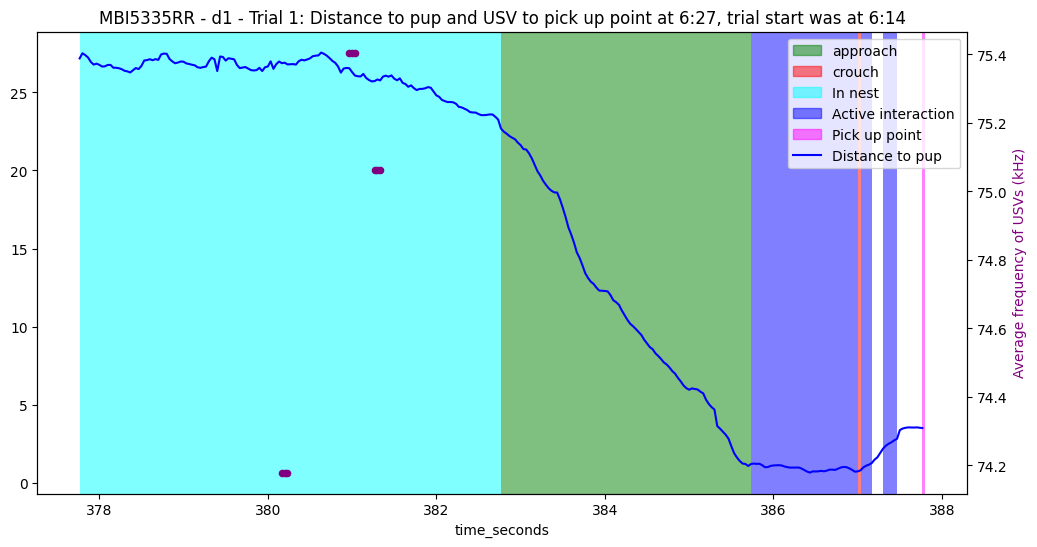

2. Trial extracted
{'in_nest': 4.999999999999992, 'active_interaction': 1.5666666666666682, 'approach': 2.966666666666666, 'crouching': 0.03333333333333333}
3. Video annotated
4. Video saved to: data/MBI5335RR/MBI5335RR_240304_d1/MBI5335RR_d1_1_pickup_shaded.mp4
4. Plot saved to: data/MBI5335RR/MBI5335RR_240304_d1/MBI5335RR_d1_1_pickup_annotated.png


<Figure size 640x480 with 0 Axes>

In [88]:
# Apply the whole pipeline

def run_video_creation(video_dict, 
                        experiment_data,
                        mouse_id, day, trial_num):  

    ## 0. Load the video path
    video_path = video_dict[mouse_id][day]
    print("0. Video loaded from:", video_path)

    ## 1. Labeling the behaviors
    pickup_time, start_trial, end_trial = find_pickup_point_in_video(experiment_data,
                                                                    mouse_id, day, trial_num)
    window = label_pup_interaction_behaviors(experiment_data,
                                            mouse_id, day, trial_num,
                                            event_time_point = pickup_time,
                                            kernel_size=20,
                                            pre_event_window_size_time=10,
                                            frame_rate=30)
    print("1. Behaviors labeled")
    start_time, end_time = window["time_seconds"].iloc[0], window["time_seconds"].iloc[-1] 
    print("Start time:", start_time, "End time:", end_time)   
    print("Pickup time:", pickup_time, "in mins:", f"{str(int(pickup_time//60))}:{int(pickup_time%60)}")
    #end_time += 1/30*10 # add 5 frames to the end time to make sure we get the last frame

    # create plot for labeled window
    plot_pup_usv_to_pickup_point(experiment_data,
                                 mouse_id, day, trial_num, window)


    ## 2. Extract a specific trial
    trial_video = extract_trial_video_efficient(video_path, experiment_data,
                                            mouse_id, day, trial_num,
                                            start_time, end_trial)
    print("2. Trial extracted")
    ## 3. Annotating the video
    # Get the frame index for pickup
    pickup_frame_index = window["frame_index"].iloc[-1]

    # Apply shading
    shaded_video = apply_behavior_shading(
        trial_video,
        window,
        pickup_frame_index,
        alpha=0.3,
        pickup_window_size=5
    )
    print("3. Video annotated")
    ## 4. Save the video
    original_path = video_dict[mouse_id][day]

    movie_name = f"{mouse_id}_{day}_{trial_num}_pickup_shaded.mp4"
    path_to_save = original_path.split("/")[:-1] + [movie_name]

    image_name = f"{mouse_id}_{day}_{trial_num}_pickup_annotated.png"
    plot_path = original_path.split("/")[:-1] + [image_name]

    path_to_save = "/".join(path_to_save)
    plot_path = "/".join(plot_path)

    print("4. Video saved to:", path_to_save)
    print("4. Plot saved to:", plot_path)

    save_trial_video(shaded_video, output_path = path_to_save, fps = 30)
    plt.savefig(plot_path)

    #return path_to_save, total_seconds

mouse_id, day, trial_num = interesting_trial_ids[1]

run_video_creation(DL.video_dict, experiment_data, mouse_id, day, trial_num)

In [39]:
# # Get the frame index for pickup
# original_path = DL.video_dict[mouse_id][day]
# movie_name = f"{mouse_id}_{day}_{trial_num}_pickup_shaded.mp4"
# path_to_save = original_path.split("/")[:-1] + [movie_name]
# path_to_save = "/".join(path_to_save)

# save_trial_video(shaded_video, output_path = path_to_save, fps = 30)

0. Video loaded from: data/MBI5335RR/MBI5335RR_240304_d1/MBI5335RR_d1DLC_resnet50_behav_trajectories_Oct2024Oct24shuffle1_100000_filtered_labeled.mp4
1. Behaviors labeled
Start time: 377.76666666666665 End time: 387.76666666666665
Pickup time: 387.766 in mins: 6:27
2. Trial extracted
{'in_nest': 4.7666666666666595, 'active_interaction': 1.5666666666666682, 'approach': 3.1999999999999984, 'crouching': 0.03333333333333333}
3. Video annotated
4. Video saved to: data/MBI5335RR/MBI5335RR_240304_d1/MBI5335RR_d1_1_pickup_shaded.mp4
4. Plot saved to: data/MBI5335RR/MBI5335RR_240304_d1/MBI5335RR_d1_1_pickup_annotated.png
0. Video loaded from: data/VBQ0261L/VBQ0261L_240223_d2/VBQ0261L_d2DLC_resnet50_behav_trajectories_Oct2024Oct24shuffle1_100000_filtered_labeled.mp4
1. Behaviors labeled
Start time: 822.4 End time: 832.4
Pickup time: 832.396 in mins: 13:52
2. Trial extracted
{'in_nest': 8.233333333333315, 'active_interaction': 0, 'approach': 1.633333333333335, 'crouching': 0}
3. Video annotated
4

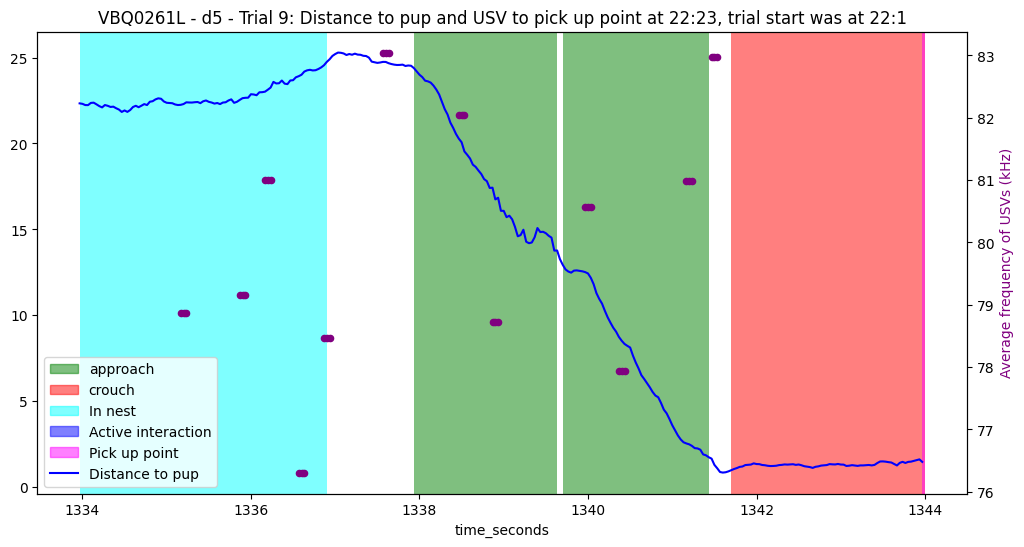

In [95]:
interesting_trial_ids = [("MBI5335RR", "d1", 1),
                        ("VBQ0261L", "d2", 4),
                        ("MBI5335RR", "d3", 4),
                        ("VBQ0261L", "d4", 6), 
                        ("VBQ0261L", "d5", 9)]

for triple in interesting_trial_ids:
    mouse_id, day, trial_num = triple
    run_video_creation(DL.video_dict.copy(), experiment_data.copy(), mouse_id, day, trial_num)

In [94]:
interesting_trial_ids

[('VBQ0261L', 'd4', 6),
 ('MBI5335RR', 'd1', 1),
 ('VBQ0261L', 'd2', 4),
 ('MBI5335RR', 'd3', 4)]